# ESS  McStas School day 3
Two exciting topics that I have spent many years developing:
- McStasScript
- Union components

Before we start, please get the new docker image with updates, version 2.1. We will need this version for the exercises!

```
docker run -p 8888:8888 docker.io/mccode/mcstas-2.7.1-3.1-scipp:2.1
```


# McStasScript
McStasScript allows writing and running McStas simulations directly from python.

Written by Mads Bertelsen while working at ESS DMSC.

Funded by PaNOSC and a part of PaNOSC work package 5.

### Installation
McStasScript is open source and available here: https://github.com/PaNOSC-ViNYL/McStasScript

Easy to install, install McStas as normal and then McStasScript can be installed with:
```
pip install McStasScript --upgrade
```

![normal](figures/Slide1.png)

![McStasScript](figures/Slide2.png)

# Live demo of McStasScript
Here we will set up an instrument simulation together and execute it from the slides!
First we import the package.

In [1]:
import mcstasscript as ms

## Configuration
Before using McStasScript for the first time, it needs to be configured to find your McStas and/or McXtrace installation.

In [2]:
configurator = ms.Configurator()
configurator.set_mcrun_path("/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1/bin/")
configurator.set_mcstas_path("/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1")
print(configurator)

Configurator:
 paths:
  mcrun_path: /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1/bin/
  mcstas_path: /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1
  mcxtrace_path: /Applications/McXtrace-1.5.app/Contents/Resources/mcxtrace/1.5/
  mxrun_path: /Applications/McXtrace-1.5.app/Contents/Resources/mcxtrace/1.5/bin/
 other:
  characters_per_line: 85



## Create instrument objects
The main class is the McStas_instr, used for creating instrument objects.

In [3]:
instrument = ms.McStas_instr("demo", author="Mads Bertelsen")

## Help from the instrument object
The instrument object knows about your available McStas components, and has help methods available.

In [4]:
instrument.available_components()

Here are the available component categories:
 contrib
 misc
 monitors
 obsolete
 optics
 samples
 sources
 union
Call available_components(category_name) to display


In [5]:
instrument.available_components("sources")

Here are all components in the sources category.
 Adapt_check     Moderator           Source_Optimizer   Source_gen
 ESS_butterfly   Monitor_Optimizer   Source_adapt       Source_simple
 ESS_moderator   Source_Maxwell_3    Source_div         


In [ ]:
instrument.component_help("Moderator")

## Adding components
McStas simulations rely on a sequence of components, these can be added to the instrument object with the *add_component* method. These return an instrument object that can be used to modify the component further.

In [6]:
src = instrument.add_component("source", "Source_div")
instrument.show_components()

source Source_div AT (0, 0, 0) ABSOLUTE


In [7]:
print(src)

COMPONENT source = Source_div
  xwidth : Required parameter not yet specified
  yheight : Required parameter not yet specified
  focus_aw : Required parameter not yet specified
  focus_ah : Required parameter not yet specified
AT [0, 0, 0] ABSOLUTE


The component parameters become python attributes on the component object.

In [8]:
src.xwidth = 0.1
src.yheight = 0.05
src.focus_aw = 1.2
src.focus_ah = 2.3
print(src)

COMPONENT source = Source_div
  xwidth = 0.1 [m]
  yheight = 0.05 [m]
  focus_aw = 1.2 [deg]
  focus_ah = 2.3 [deg]
AT [0, 0, 0] ABSOLUTE


Notice the attributes on component objects auto complete and wrong attributes are not allowed.

In [9]:
src.focus_ah = 2.5

### All information about a component
The *show_parameters* method is good for getting an overview of the current state of the component parameters, as it will also show the default values.

In [10]:
src.show_parameters()

 ___ Help Source_div ________________________________________________________________
|optional parameter|required parameter|default value|user specified value|
xwidth = 0.1 [m] // Width of source
yheight = 0.05 [m] // Height of source
focus_aw = 1.2 [deg] // FWHM (Gaussian) or maximal (uniform) horz. width 
                        divergence 
focus_ah = 2.5 [deg] // FWHM (Gaussian) or maximal (uniform) vert. height 
                        divergence 
E0 = 0.0 [meV] // Mean energy of neutrons.
dE = 0.0 [meV] // Energy half spread of neutrons.
lambda0 = 0.0 [Ang] // Mean wavelength of neutrons (only relevant for E0=0)
dlambda = 0.0 [Ang] // Wavelength half spread of neutrons.
gauss = 0.0 [0|1] // Criterion
flux = 1.0 [1/(s cm 2 st energy_unit)] // flux per energy unit, Angs or meV
-------------------------------------------------------------------------------------


## Add instrument parameters
Its also possible to add instrument parameters, and these can be used directly when setting component parameters.

In [11]:
instrument.add_parameter("int", "order", value=1, comment="Monochromator order, integer")
instrument.show_parameters()

int order  = 1  // Monochromator order, integer


In [12]:
src.lambda0 = instrument.add_parameter("wavelength", value=2.0, comment="Wavelength in [Ang]")
src.dlambda = "0.01*wavelength"
print(src)

COMPONENT source = Source_div
  xwidth = 0.1 [m]
  yheight = 0.05 [m]
  focus_aw = 1.2 [deg]
  focus_ah = 2.5 [deg]
  lambda0 = wavelength [Ang]
  dlambda = 0.01*wavelength [Ang]
AT [0, 0, 0] ABSOLUTE


### Setting component positions
When creating a new component, one can specify its position and rotation. 

In [13]:
guide = instrument.add_component("guide", "Guide_gravity", AT=[0,0,1], RELATIVE=src)

In [14]:
guide.set_parameters(w1=0.05, h1=0.05, l=8.0, m=3.5, G=-9.82)
print(guide)

COMPONENT guide = Guide_gravity
  w1 = 0.05 [m]
  h1 = 0.05 [m]
  l = 8.0 [m]
  m = 3.5 [1]
  G = -9.82 [m/s2]
AT [0, 0, 1] RELATIVE source


One can always set the positon and rotation of component objects with the appropriate methods at a later point.

In [15]:
guide.set_AT([0, 0, 2], RELATIVE="source")

### Adding initialize code
Its possible to add lines of C code to the initialize section of the written McStas file, but its equally possible to just perform these calculations directly in python. Here I show how calculate rotation of a monochromator before we add such a component.

In [16]:
instrument.add_declare_var("double", "mono_Q", value=2*3.14159/1.714) # Q for Ge 311
instrument.add_declare_var("double", "wavevector")
instrument.append_initialize("wavevector = 2.0*PI/wavelength;")

instrument.add_declare_var("double", "mono_rotation")
instrument.append_initialize("mono_rotation = asin(mono_Q/(2.0*wavevector))*RAD2DEG;")

### Adding a monochromator
We can now add a monochromator that use the calculated rotation.

In [17]:
mono = instrument.add_component("mono", "Monochromator_flat")

In [18]:
mono.set_parameters(zwidth=0.05, yheight=0.08, Q="mono_Q")
mono.set_AT([0, 0, guide.l + 0.5], RELATIVE=guide)
mono.set_ROTATED([0, "mono_rotation", 0], RELATIVE="guide")

print(mono)

COMPONENT mono = Monochromator_flat
  zwidth = 0.05 [m]
  yheight = 0.08 [m]
  Q = mono_Q [1/angstrom]
AT [0, 0, 8.5] RELATIVE guide
ROTATED [0, 'mono_rotation', 0] RELATIVE guide


Need to set the beam direction to the direction of the scattered beam

In [19]:
beam_direction = instrument.add_component("beam_dir", "Arm", AT_RELATIVE=mono)
beam_direction.set_ROTATED([0, "mono_rotation", 0], RELATIVE=mono)

### Adding a sample
Now we can set up a simple powder sample to get some mildly interesting data.

In [20]:
sample = instrument.add_component("sample", "PowderN", AT=[0,0,1.1], RELATIVE="beam_dir")

In [21]:
sample.radius = 0.015
sample.yheight = 0.05
sample.reflections = '"Na2Ca3Al2F14.laz"'
print(sample)

COMPONENT sample = PowderN
  reflections = "Na2Ca3Al2F14.laz" []
  radius = 0.015 [m]
  yheight = 0.05 [m]
AT [0, 0, 1.1] RELATIVE beam_dir


### Adding a few monitors
At the end we add a few monitors, a two theta banana detector and a transmission PSD.

In [22]:
banana = instrument.add_component("banana", "Monitor_nD", RELATIVE=sample)
banana.xwidth = 2.0
banana.yheight = 0.3
banana.restore_neutron = 1
banana.filename = '"banana.dat"'
banana.options = '"theta limits=[5 175] bins=150, banana"'

mon = instrument.add_component("monitor", "PSD_monitor")
mon.nx = 100
mon.ny = 100
mon.filename = '"psd.dat"'
mon.xwidth = 0.05
mon.yheight = 0.08
mon.restore_neutron = 1
mon.set_AT([0,0,0.1], RELATIVE=sample)

### Checking our instrument object
Before running our simulation we can check the contents of the instrument object and ensure its reasonable.

In [23]:
instrument.show_components()

source   Source_div         AT      (0, 0, 0)             ABSOLUTE         
guide    Guide_gravity      AT      (0, 0, 2)             RELATIVE source  
mono     Monochromator_flat AT      (0, 0, 8.5)           RELATIVE guide    
                            ROTATED (0, mono_rotation, 0) RELATIVE guide
beam_dir Arm                AT      (0, 0, 0)             RELATIVE mono     
                            ROTATED (0, mono_rotation, 0) RELATIVE mono
sample   PowderN            AT      (0, 0, 1.1)           RELATIVE beam_dir
banana   Monitor_nD         AT      (0, 0, 0)             RELATIVE sample  
monitor  PSD_monitor        AT      (0, 0, 0.1)           RELATIVE sample  


In [24]:
instrument.show_parameters()

int order       = 1    // Monochromator order, integer
    wavelength  = 2.0  // Wavelength in [Ang]


### Instrument diagram
Instrument diagram can be generated to provide an overview of the instrument.

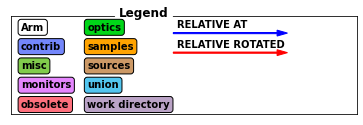

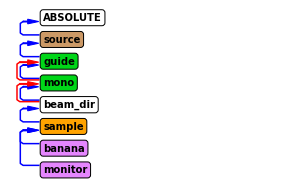

In [25]:
instrument.show_diagram()

## Visualizing the instrument
Can visualize the instrument directly from the notebook

In [27]:
instrument.show_instrument(width=1000,height=800)

### Runnig our simulation
Now we can run the simulation directly from python.

In [28]:
instrument.settings(ncount=5E6, output_path="data_folder/mcstas_basics")
instrument.set_parameters(wavelength=2.8)
data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/McStas/McStas_teaching/Schools/2022/ESS_May_June_2022/Day3_Monday_July_4th/07_McStasScript/data_folder/mcstas_basics_2"
INFO: Regenerating c-file: demo.c
CFLAGS=
INFO: Recompiling: ./demo.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
1 warning generated.
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy demo.instr in dataset /Users/madsbertelsen/McStas/McStas_teaching/Schools/2022/ESS_May_June_2022/Day3_Monday_July_4th/07_McStasScript/data_folder/mcstas_basics_2

      Opening input file '/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//data/Na2Ca3Al2F14.laz' (Table_Read_Offset)
Table from file 'Na2Ca3Al2F14.laz' (block 1) is 841 x 18 (x=1:20), constant step. interpolation: linear
  '# TITLE *-Na2Ca3Al2F14-[I213] Courbion, G.;Ferey, G.[1988] Standard NAC cal ...'
PowderN: sample: Reading 841 rows from Na2Ca3Al2F14.laz
Powd

### Plotting the data
The *run_full_instrument* method returns a data object that we can plot.

In [29]:
print(data)

[
McStasData: banana type: 1D  I:1.22934e-06 E:2.15689e-08 N:10271, 
McStasData: monitor type: 2D  I:6.25302e-05 E:3.07191e-07 N:99545]


Plotting data with name banana
Plotting data with name monitor


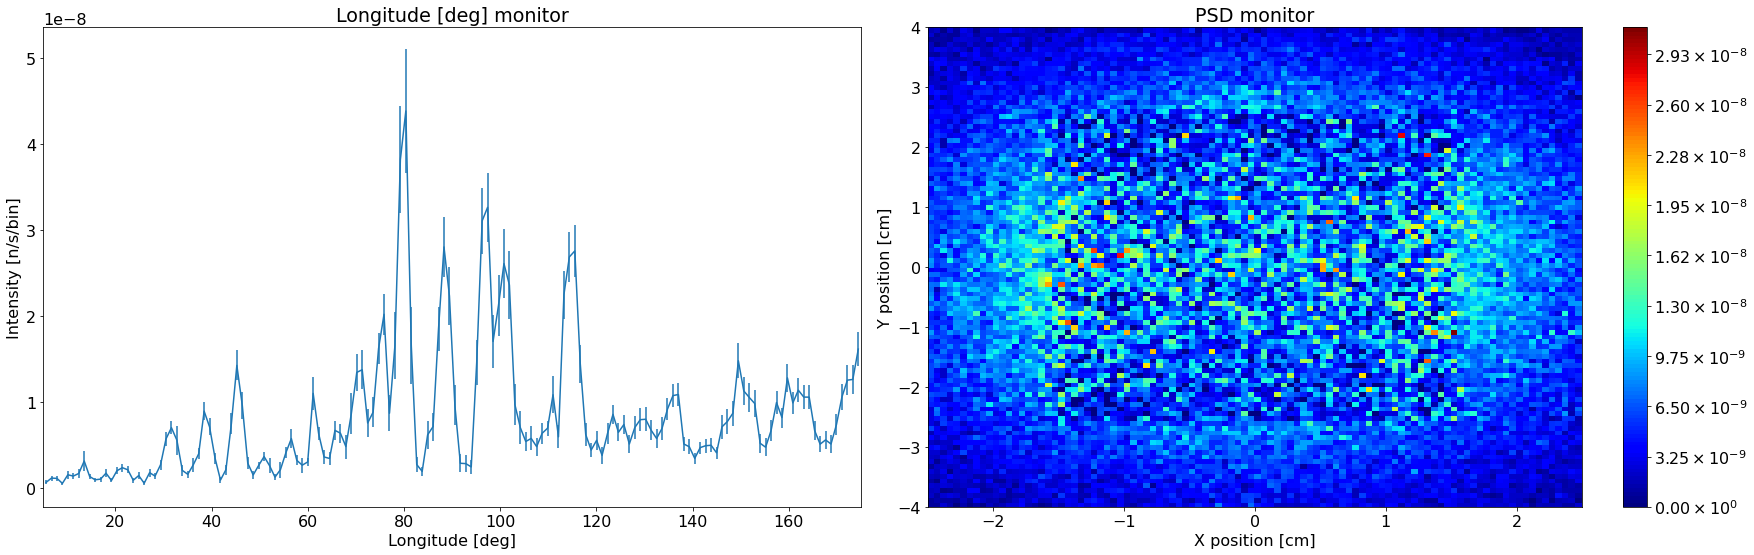

In [30]:
ms.make_sub_plot(data, fontsize=16, figsize=(25, 8))

### Plotting interface
A widget interface is also available for plotting.

In [31]:
%matplotlib widget
import mcstasscript.jb_interface as ms_widget
ms_widget.show(data)

### Simulation interface

In [34]:
ms_widget.show(instrument)

### Simulation interface

In [35]:
import POWTOF
ms_widget.show(POWTOF.make_instrument())

### Setting plotting options
Its also possible to adjust the way data is plotted, and these preferences are stored in the data object.

In [36]:
ms.name_plot_options("banana", data, left_lim=90, right_lim=150)
ms.name_plot_options("monitor", data, log=True, orders_of_mag=3)
ms.make_sub_plot(data, fontsize=12, figsize=(9, 4))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Plotting data with name banana
Plotting data with name monitor


### Access to the underlying data
The underlying data is read from the McStas data files and imported as numpy arrays.

In [37]:
import numpy as np
banana = ms.name_search("banana", data)
print(banana)

McStasData: banana type: 1D  I:1.22934e-06 E:2.15689e-08 N:10271


In [38]:
print(banana.Intensity[1:10])

[1.13143305e-09 1.09473068e-09 5.14975093e-10 1.51522587e-09
 1.36718037e-09 1.66844784e-09 3.11883729e-09 1.31823266e-09
 9.31926233e-10]


### Plot with matplotlib

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(banana.xaxis, banana.Intensity)
plt.xlabel("Two theta [deg]")
plt.ylabel("Intensity [n/s/bin]")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Final remarks
McStasScript provides a new way to use McStas from python!

A full tutorial exist as Jupyter Notebooks, this presentation was a condensed version of the first part called McStas_basics.
The tutorial covers both how to use McStasScript and the Union components.

Documentaton and tutorials can be found here [https://mads-bertelsen.github.io](https://mads-bertelsen.github.io)

## Exercise

There is a quiz in the McStasScript-notebooks folder in the new docker!

Before starting it is important you update to the latest version. From the docker, open a terminal and type:
```
cd McStasScript-notebooks
git pull
```